Problem statement: To build a deep learning image segmentation model to correctly identify 4 types of defects on the images. Identifying different types of steel sheet defects is critical to improving the company's and industry's automation, increasing efficiency, and maintaining high quality in production.

### Importing all the important libraries

In [83]:
# !pip install -q -U keras-tuner

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import os
import cv2
import keras_tuner as kt
import PIL
from PIL import Image
from tensorflow import keras
from keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [85]:
# from google.colab import drive
# drive.mount(-'/content/gdrive')

# `EXPLORATORY DATA ANALYSIS`

This assignment uses a dataset of about 6666 images of steel sheet defect types. The dataset contains 4679 images in train, 1308 images in validation, and 679 images in test subdirectories. In each subdirectory they contains their respective CSV files.

In [2]:
# Defining the path for train, validate, and test images

data_dir_train = pathlib.Path("D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/train")
data_dir_validate = pathlib.Path("D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/valid")
data_dir_test = pathlib.Path("D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/test")

In [3]:
# paths to your CSV files
csv_file_train = "D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/train/_classes.csv"
csv_file_validate = "D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/valid/_classes.csv"
csv_file_test = "D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/test/_classes.csv"

# Read CSV files
df_train = pd.read_csv(csv_file_train)
df_validate = pd.read_csv(csv_file_validate)
df_test = pd.read_csv(csv_file_test)

# Count images in training CSV
image_count_train = len(df_train)
print("Number of images in training CSV:", image_count_train)

# Count images in validation CSV
image_count_validate = len(df_validate)
print("Number of images in validation CSV:", image_count_validate)

# Count images in test CSV
image_count_test = len(df_test)
print("Number of images in test CSV:", image_count_test)


Number of images in training CSV: 4679
Number of images in validation CSV: 1308
Number of images in test CSV: 679


In [4]:
# Print the shape of each CSV file
print("Shape of Training CSV:", df_train.shape)
print("Shape of Validation CSV:", df_validate.shape)
print("Shape of Test CSV:", df_test.shape)

Shape of Training CSV: (4679, 5)
Shape of Validation CSV: (1308, 5)
Shape of Test CSV: (679, 5)


In [5]:
# Display top 5 rows of train CSV file
print("\nTop 5 rows of Training CSV:")
df_train.head()


Top 5 rows of Training CSV:


,filename,class-1,class-2,class-3,class-4
0,82b23f53c_jpg.rf.07f70fcc3e9b12b98d966a6b852d3...,0,0,1,0
1,844a48ae2_jpg.rf.07fe44a03121491ea042c77086120...,0,0,1,0
2,4cf3b3988_jpg.rf.0832e7076083ce7bebc7d115f9448...,1,0,0,0
3,a3a66a86a_jpg.rf.0852a027e146a1e1061fb497a528f...,0,0,1,0
4,30ed4ed02_jpg.rf.0861469ede3819d8fb5a80fc3003a...,0,0,0,1


In [6]:
print("\nTop 5 rows of Validation CSV:")
df_validate.head()


Top 5 rows of Validation CSV:


,filename,class-1,class-2,class-3,class-4
0,238d6df92_jpg.rf.00921470c2d3e475037e64212585b...,0,0,1,0
1,fce971b43_jpg.rf.013f3fb6891623a7ccbc776793bda...,0,0,1,0
2,9ba68fdaa_jpg.rf.01613c2c4724517732466fbf97c03...,0,0,1,0
3,9753787e9_jpg.rf.01437b831d0a15ecc7bffebeab2b4...,0,0,1,1
4,6860ae804_jpg.rf.0190318e72cea5be5a234376d5936...,0,0,1,0


In [7]:
print("\nTop 5 rows of Test CSV:")
df_test.head()


Top 5 rows of Test CSV:


,filename,class-1,class-2,class-3,class-4
0,252c10c1a_jpg.rf.00a0c09b26d84c2cf4e7efc431b78...,0,0,1,0
1,fbcb3df55_jpg.rf.00c39ac1f09905ddd042ee7cdb8ec...,0,0,1,0
2,c74abe00a_jpg.rf.00c47247b98dda59db402dc2e990f...,0,0,1,0
3,bba274c50_jpg.rf.014a29b62511869be8b7ce532ff78...,0,0,1,0
4,1d5f3ecb8_jpg.rf.016eb39f80b8b2f0096af6a0d4ab8...,0,0,1,0


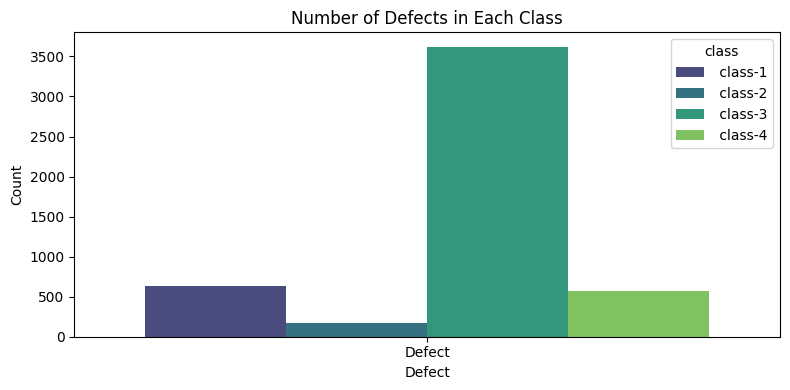

In [8]:
# Melt the DataFrame to convert the class columns into rows
melted_df = df_train.melt(id_vars=['filename'], var_name='class', value_name='defect')
melted_df['defect'] = melted_df['defect'].map({0: 'No Defect', 1: 'Defect'})

# Filter only rows where defect is 'Defect'
defect_df = melted_df[melted_df['defect'] == 'Defect']

# Create the countplot
plt.figure(figsize=(8, 4))
sns.countplot(x='defect', data=defect_df, hue='class', palette='viridis')
plt.title('Number of Defects in Each Class')
plt.xlabel('Defect')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The analysis reveals that `Class-3` contains a higher number of images with defects compared to other classes.

Now let's see the exact number of each class.

In [9]:
# Calculate the count of defects in each class
defect_counts = defect_df.groupby('class')['defect'].count().reset_index()
defect_counts.columns = ['class', 'defect_count']

# Display the count of defects in each class
print(defect_counts)

      class  defect_count
0   class-1           629
1   class-2           166
2   class-3          3620
3   class-4           569


Clearly, we can see that `Class-3` type defects are more prevalent compared to other defect types in the dataset.

Now, we visualize one instance of each type of defect present in the dataset

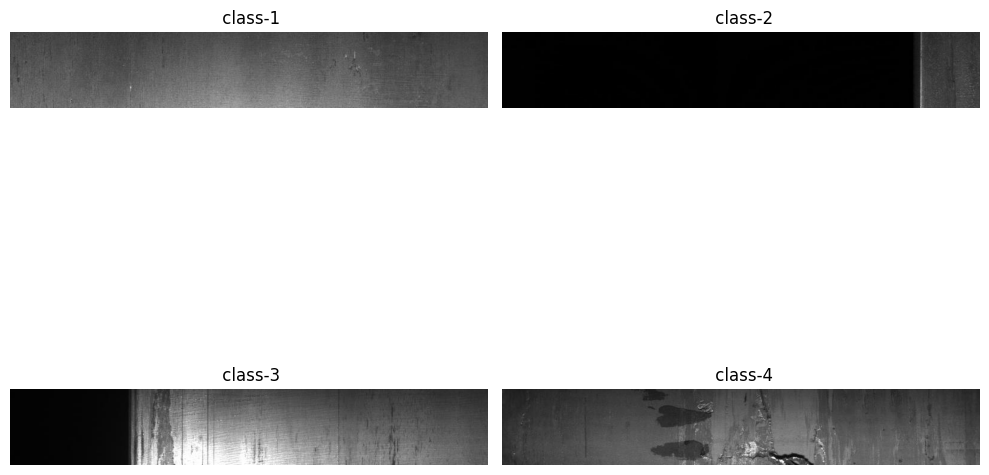

In [10]:
# Define class names
class_names = df_train.columns[1:]  # Exclude the first column (filename)

# Create a figure for plotting
plt.figure(figsize=(10, 10))

# Loop through each class and plot one image
for i, class_name in enumerate(class_names, 1):
    # Find the first image for this class
    image_row = df_train[df_train[class_name] == 1].iloc[0]  # Assumes 1 indicates presence of defect
    image_filename = image_row['filename']

    # Load and plot the image
    image_path = f'D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/train/{image_filename}'  # Replace with the path to your image folder
    image = Image.open(image_path)

    plt.subplot(2, 2, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

# `MODEL BUILDING`

## Convolutional Neural Network (CNN)

After performing all the preprocessing steps we will start with building our model using `Convolutional Neural Network (CNN)`.

Define some parameters for the loader:

In [11]:
img_width, img_height = 256, 256
batch_size = 64
num_epochs = 10

In [12]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# Load training data from directory with labels from the CSV file
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=data_dir_train,
    x_col="filename",
    y_col=[" class-1", " class-2", " class-3", " class-4"],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='raw'
)

Found 4679 validated image filenames.


In [14]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs
)

Epoch 1/10


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.6757 - loss: 43.1179
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 402us/step - accuracy: 0.1406 - loss: 4552.9668
Epoch 3/10


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


73/73 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6235 - loss: 252079.2344
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 58us/step - accuracy: 0.8438 - loss: 2567600.7500
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5822 - loss: 42435976.0000
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - accuracy: 0.7969 - loss: 97434688.0000   
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6170 - loss: 633228544.0000
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 70us/step - accuracy: 0.7656 - loss: 2146485248.0000
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6038 - loss: 7159148544.0000
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/step - accuracy: 0.8438 - loss: 6677748736.0000   


In [17]:
# Save the trained model
model.save('D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/cnn_model_with_csv.h5')
print("CNN Model trained and saved.")

CNN Model trained and saved.


Training of Model is done. Now, we need to evaluate the model on our validation dataset.

## Evaluating the Model on Validation Dataset

In [18]:
# Load the trained CNN model
model = load_model('D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/cnn_model_with_csv.h5')

In [19]:
# Data augmentation for validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

# Load validation data from directory with labels from the CSV file
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_validate,
    directory=data_dir_validate,
    x_col="filename",
    y_col=[" class-1", " class-2", " class-3", " class-4"],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False  # Important to keep the same order as predictions
)

Found 1308 validated image filenames.


In [20]:
# Evaluate the model on the validation dataset
eval_results = model.evaluate(valid_generator)

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 834ms/step - accuracy: 0.7386 - loss: 18812166144.0000


In [21]:
# Print the evaluation results (loss and accuracy)
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])

Validation Loss: 18343956480.0
Validation Accuracy: 0.7469419240951538


In [22]:
# Get predictions for the validation dataset
valid_generator.reset()  # Reset the generator to the beginning
y_pred = model.predict(valid_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step


In [23]:
# Assuming you want to extract class predictions from probabilities
# You can choose the class with the highest probability for each sample
y_pred_classes = np.argmax(y_pred, axis=1)

In [24]:
# Get true labels for the validation dataset
y_true = df_validate[[" class-1", " class-2", " class-3", " class-4"]].values
y_true_classes = np.argmax(y_true, axis=1)

In [25]:
# Calculate additional evaluation metrics if needed
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00        50
           2       0.75      1.00      0.86       977
           3       0.00      0.00      0.00       105

    accuracy                           0.75      1308
   macro avg       0.19      0.25      0.21      1308
weighted avg       0.56      0.75      0.64      1308

Confusion Matrix:
[[  0   0 176   0]
 [  0   0  50   0]
 [  0   0 977   0]
 [  0   0 105   0]]
Accuracy: 0.7469418960244648
Precision: 0.8109803000121575
Recall: 0.7469418960244648
F1 Score: 0.6387415601014461


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

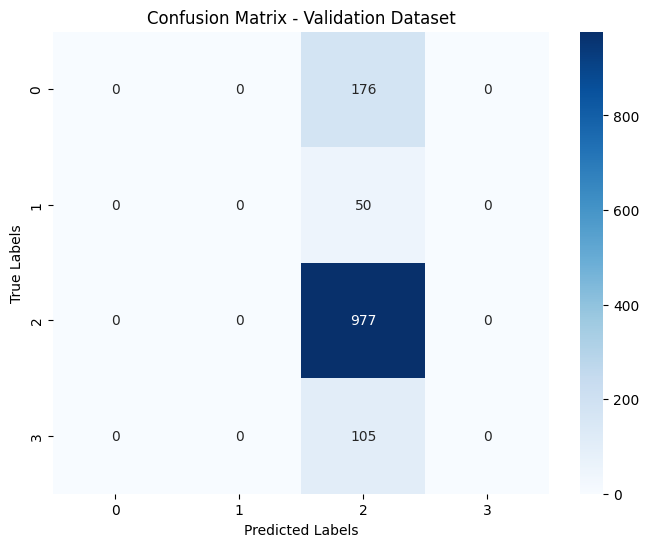

In [26]:
# Save the evaluation results or visualization if needed
# For example, save the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Validation Dataset")
plt.show()

## Hyperparameter Tuning

In [27]:
# Define the model builder function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/',
    project_name='cnn_hyperparameter_tuning'
)

Reloading Tuner from D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/cnn_hyperparameter_tuning\tuner0.json


In [29]:
# Perform the hyperparameter search
tuner.search(train_generator,
             steps_per_epoch=train_generator.samples // batch_size,
             epochs=num_epochs,
             validation_data=valid_generator,
             validation_steps=valid_generator.samples // batch_size)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [30]:
# Save the best hyperparameters to a file
best_hps_file = 'best_hyperparameters.txt'
with open(best_hps_file, 'w') as f:
    f.write(str(best_hps.get_config()))

In [31]:
# Define the final model using the best hyperparameters
final_model = build_model(best_hps)

# Train the final model on the full training dataset
final_model.fit(train_generator,
                steps_per_epoch=train_generator.samples // batch_size,
                epochs=num_epochs,
                validation_data=valid_generator,
                validation_steps=valid_generator.samples // batch_size)

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 511s 7s/step - accuracy: 0.6712 - loss: 6.8548 - val_accuracy: 0.7461 - val_loss: 158.3716
Epoch 2/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 7:45 6s/step - accuracy: 0.7969 - loss: 117.6916

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7969 - loss: 59.6519 - val_accuracy: 0.5714 - val_loss: 54.2448
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 463s 6s/step - accuracy: 0.5701 - loss: 440.9932 - val_accuracy: 0.7453 - val_loss: 3650.8354
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8281 - loss: 1344.0441 - val_accuracy: 0.8214 - val_loss: 2241.2302
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step - accuracy: 0.6077 - loss: 11752.4688 - val_accuracy: 0.7461 - val_loss: 70167.9297
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7031 - loss: 46069.9219 - val_accuracy: 0.8571 - val_loss: 22393.6348
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 492s 7s/step - accuracy: 0.6100 - loss: 81468.5781 - val_accuracy: 0.7453 - val_loss: 303208.2500
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7500 - loss: 148094.2969 - val_accuracy: 0.8214 - val_loss: 101043.0547
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.5871 - loss:

In [32]:
# Save the final trained model
final_model.save('D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/final_model.h5')

## Testing the Trained Model on Test Dataset

In [33]:
# Create the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=data_dir_test,
    x_col="filename",
    y_col=[" class-1", " class-2", " class-3", " class-4"],  # Setting y_col to None because we manually created the labels
    class_mode='raw',  # Setting class_mode to None for custom labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)

Found 679 validated image filenames.


In [34]:
# Now test your model using the test generator
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - accuracy: 0.7689 - loss: 18133403648.0000
Test Loss: 17192636416.0
Test Accuracy: 0.7614138722419739


In [35]:
# Get predictions for the test dataset
test_generator.reset()  # Reset the generator to the beginning
y_pred_final = final_model.predict(test_generator)

# Assuming you want to extract class predictions from probabilities
# You can choose the class with the highest probability for each sample
y_pred_classes_final = np.argmax(y_pred_final, axis=1)

# Get true labels for the validation dataset
y_true = df_test[[" class-1", " class-2", " class-3", " class-4"]].values
y_true_classes_final = np.argmax(y_true, axis=1)

# Get true labels for the test dataset
# This assumes that your test dataset generator returns one-hot encoded labels
# y_true_classes_final = test_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


In [36]:
# Calculate additional evaluation metrics if needed
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes_final, y_pred_classes_final))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes_final, y_pred_classes_final)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes_final, y_pred_classes_final)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes_final, y_pred_classes_final, average='weighted', zero_division=1)
recall = recall_score(y_true_classes_final, y_pred_classes_final, average='weighted', zero_division=1)
f1 = f1_score(y_true_classes_final, y_pred_classes_final, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.00      0.00      0.00        23
           2       0.76      1.00      0.86       517
           3       0.00      0.00      0.00        47

    accuracy                           0.76       679
   macro avg       0.19      0.25      0.22       679
weighted avg       0.58      0.76      0.66       679

Confusion Matrix:
[[  0   0  92   0]
 [  0   0  23   0]
 [  0   0 517   0]
 [  0   0  47   0]]
Accuracy: 0.7614138438880707
Precision: 0.8183371977763365
Recall: 0.7614138438880707
F1 Score: 0.6582791927928637


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

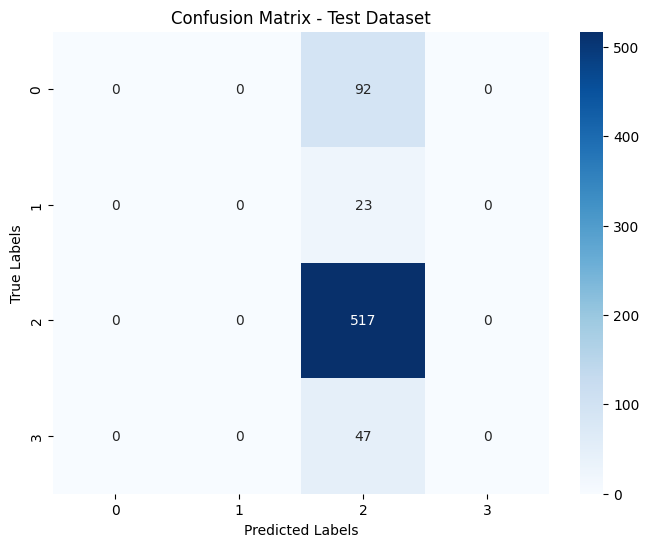

In [37]:
# Save the evaluation results or visualization if needed
# For example, save the confusion matrix plot

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Dataset")
plt.show()

In [38]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 96)   │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 369024)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    94,470,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,757,102 (1.06 GB)

 Trainable params: 94,585,700 (360.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 189,171,402 (721.63 MB)

In [39]:
# Load the trained CNN model
final_model = load_model('D:/capstone project/severstal-steel-defect-detection.v1i.multiclass/final_model.h5')

# Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])